# 🎲 Transpilation Overview

**Quantum Transpilation** is the transformation of a given virtual quantum circuit:

- to match the topology of a specific device
- to optimize the circuit for execution

Rivet Transpiler package provides a family of functions for efficient transpilation of quantum circuits.

### Transpilation Stages

1) **Init** - Unrolling custom instructions and converting the circuit to all 1 and 2 qubit gates.

2) **Layout** - Mapping circuit virtual qubits to backend physical qubits.

3) **Routing** - Inject SWAP gates to comply with the backend’s coupling map.

4) **Translation** - Translate to the target backend’s basis gate set.

5) **Optimization** - Main optimization loop to increase circuit quality.

6) **Scheduling** - Conversion to hardware-specific pulses.

In [1]:
# https://qiskit.org/documentation/apidoc/transpiler.html

### Transpile Functions

`transpile` - custom transpilation with possibility of using:

- different transpilation stacks
- custom PassManager
- dynamical decoupling
- transpiler options

`transpile_chain` - consistently transpile and "stitch" a chain of quantum circuits.

`transpile_right` - transpile an additional circuit to the right part of the existing circuit.

`transpile_left` - transpile an additional circuit to the left part of the existing circuit.

`transpile_and_compress` - transpile and "topologically compress" a circuit considering a coupling map of the selected backend.

# 🎱 Transpilation Examples

In [2]:
import qiskit

from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2

In [3]:
# Rivet Transpiler Imports

%cd ..

# Transpile Functions

from rivet_transpiler import transpile
from rivet_transpiler import transpile_chain
from rivet_transpiler import transpile_right
from rivet_transpiler import transpile_left
from rivet_transpiler import transpile_and_compress
from rivet_transpiler import transpile_and_return_metrics

# Service Functions

from rivet_transpiler import get_full_map
from rivet_transpiler import get_ibm_cost
from rivet_transpiler import get_circuit_hash

from rivet_transpiler import get_cnot_circuit
from rivet_transpiler import get_litmus_circuit

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler/docs


### Litmus Circuit

**Litmus circuit** is a minimal quantum circuit which consists of:

- Parametrized RZ gate on each qubit (each parameter name matches the  index of the virtual qubit - to trace consequent permutations of qubits during layout and routing phases of transpilation).

- Circular CNOT gates (necessary to introduce SWAPs during transpilation to not fully connected topology).

In [4]:
QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

litmus_circuit.draw()

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

### Backend

**Fake backend** is an Aer simulator with properties of a real backend:

- coupling map
- basis gates
- noise model

Fake backends are useful for testing the transpiler and performing noisy simulations of the system.

For minimal example we select 5-qubit fake backend with linear topology.

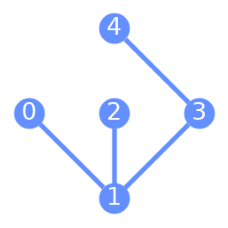

In [5]:
backend = FakeLimaV2()
# backend = FakeMontrealV2()

qiskit.visualization.plot_gate_map(backend)

### Qiskit Transpile

In [6]:
transpiled_circuit = qiskit.transpile(
    litmus_circuit, 
    backend,
    seed_transpiler=1234,
    initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_circuit.draw()

┌──────────────┐               ┌───┐             ░    
Litmus_0_0 -> 0 ┤ Rz(Litmus_0) ├──■─────────■──┤ X ├──■──────────░────
                └──────────────┘  │         │  └─┬─┘  │          ░    
                ┌──────────────┐┌─┴─┐     ┌─┴─┐  │  ┌─┴─┐┌───┐ Litmus 
Litmus_0_1 -> 1 ┤ Rz(Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├───░────
                ├──────────────┤└───┘┌─┴─┐└───┘     └───┘└─┬─┘   ░    
Litmus_0_2 -> 2 ┤ Rz(Litmus_2) ├─────┤ X ├─────────────────■─────░────
                └──────────────┘     └───┘                       ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

### Pass Manager

**Pass Manager** is an internal Qiskit object constructed by the `transpile` function "under the hood" during transpilation.

Pass Manager consists of Passes which analyse or change the transpiled circuit.

Calling `pass_manager.run` is equivalent to calling `transpile` and passing a circuit, backend and corresponding transpilation parameters.

In [7]:
# https://docs.quantum.ibm.com/api/qiskit/passmanager

In [8]:
pass_manager = qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager(
    
    optimization_level=3,
    backend=backend,
    # initial_layout=[1, 0, 2],
    seed_transpiler=1234
)

In [9]:
pass_manager.stages

('init', 'layout', 'routing', 'translation', 'optimization', 'scheduling')

In [10]:
# pass_manager.draw()

In [11]:
# pass_manager.init.draw()

In [12]:
# pass_manager.routing.draw()

In [13]:
# pass_manager.optimization.draw()

In [14]:
# pass_manager.layout.passes()

In [15]:
transpiled_litmus_circuit = pass_manager.run(litmus_circuit)

transpiled_litmus_circuit.draw(fold=-1)

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

## Circuit Stitching

**Task:** to "stitch" together transpiled circuits into a chain.

Disconnected qubits are routed closer using SWAPs gates – **but not routed back** to avoid additional SWAPs – therefore allocation of virtual qubit changes.

We need to know the final allocation of qubits after transpilation.

Unfortunately, Qiskit does not provide such allocation.

Instead - Qiskit transpiled circuit contains ‘layout’ property with data on applied qubit permutations:

- ‘initial_layout’ – initial placement of incoming virtual qubits during Layout stage.

- ‘final_layout’ – placement of outgoing virtual qubits during Routing stage.

Function `get_full_map` follows above permutations to return final allocation of qubits after transpilation.

In [16]:
get_full_map(transpiled_litmus_circuit)

[0, 2, 1, 3, 4]

To find final allocation of qubits after transpilation we work with 3 sets of qubits:

- Incoming virtual qubits of the initial circuit
- Outgoing virtual qubits of the transpiled circuit
- Physical qubits of the selected backend

Example of qubit allocation during transpilation:

- `Zero Map` - Ancillas added
- `After Layout` - Initial layout applied 
- `After Routing` - SWAPs applied 
- `Full Map` - Final qubit allocation 

![image.png](../images/Fig1_circuit_stitching.jpg)

In [17]:
transpiled_litmus_circuit.draw()

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

### Our Transpile

Interface of `transpile` function matches `qiskit.transpile` - but allows additional parameters like:

- pre-defined transpilation stacks
- custom PassManager
- dynamical decoupling
- transpiler options

In [18]:
transpiled_circuit = transpile(
    litmus_circuit, 
    backend,
    seed_transpiler=1234,
    # initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_circuit.draw()

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

Final qubit allocation after transpilation:

In [19]:
get_full_map(transpiled_circuit)

[0, 2, 1, 3, 4]

### Transpile Chain

Consistently transpile and "stitch" a chain of quantum circuits.

In [20]:
CHAIN = [litmus_circuit] * 5

transpiled_chain_circuit = transpile_chain(
    CHAIN, 
    backend,
    seed_transpiler=1234,
    initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_chain_circuit.draw(fold=-1)

┌──────────────┐               ┌───┐             ░    ┌──────────────┐┌───┐                            ░    ┌──────────────┐     ┌───┐          ┌───┐     ┌───┐             ░    ┌──────────────┐     ┌───┐          ┌───┐     ┌───┐             ░    ┌──────────────┐     ┌───┐          ┌───┐     ┌───┐             ░    
Litmus_0_1 -> 0 ┤ Rz(Litmus_0) ├──■─────────■──┤ X ├──■──────────░────┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────┤ Rz(Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■──────────░────┤ Rz(Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■──────────░────┤ Rz(Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■──────────░────
                └──────────────┘  │         │  └─┬─┘  │          ░    └──────────────┘└─┬─┘                 │          ░    └──────────────┘  │  └─┬─┘  │       └─┬─┘  │  └─┬─┘  │          ░    └──────────────┘  │  └─┬─┘  │       └─┬─┘  │  └─┬─┘  │          ░    └──────────────┘  │  └─┬─┘  │       └─┬─┘  │  └─┬─┘  │          ░    
                ┌──────────────┐┌─┴─┐     ┌─┴─┐  │  ┌─┴─┐┌───┐ Litmus ┌──────────────┐  │  ┌───┐     ┌───┐┌─┴─┐        ░    ┌──────────────┐┌─┴─┐  │  ┌─┴─┐┌───┐  │  ┌─┴─┐  │  ┌─┴─┐        ░    ┌──────────────┐┌─┴─┐  │  ┌─┴─┐┌───┐  │  ┌─┴─┐  │  ┌─┴─┐        ░    ┌──────────────┐┌─┴─┐  │  ┌─┴─┐┌───┐  │  ┌─┴─┐  │  ┌─┴─┐        ░    
Litmus_0_2 -> 1 ┤ Rz(Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├───░────┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────┤ Rz(Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■─────░────┤ Rz(Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■─────░────┤ Rz(Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■─────░────
                └──────────────┘└───┘  │  └───┘     └───┘└─┬─┘   ░    └──────────────┘     └─┬─┘  │  └─┬─┘└───┘  │     ░    └──────────────┘└───┘     └───┘└─┬─┘     └───┘     └───┘  │     ░    └──────────────┘└───┘     └───┘└─┬─┘     └───┘     └───┘  │     ░    └──────────────┘└───┘     └───┘└─┬─┘     └───┘     └───┘  │     ░    
                ┌──────────────┐     ┌─┴─┐                 │     ░    ┌──────────────┐       │  ┌─┴─┐  │       ┌─┴─┐ Litmus ┌──────────────┐                 │                      ┌─┴─┐ Litmus ┌──────────────┐                 │                      ┌─┴─┐ Litmus ┌──────────────┐                 │                      ┌─┴─┐ Litmus 
Litmus_0_0 -> 2 ┤ Rz(Litmus_2) ├─────┤ X ├─────────────────■─────░────┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────┤ Rz(Litmus_0) ├─────────────────■──────────────────────┤ X ├───░────┤ Rz(Litmus_0) ├─────────────────■──────────────────────┤ X ├───░────┤ Rz(Litmus_0) ├─────────────────■──────────────────────┤ X ├───░────
                └──────────────┘     └───┘                       ░    └──────────────┘          └───┘          └───┘   ░    └──────────────┘                                        └───┘   ░    └──────────────┘                                        └───┘   ░    └──────────────┘                                        └───┘   ░    
 ancilla_0 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                                           
 ancilla_1 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [21]:
get_full_map(transpiled_chain_circuit)

[2, 0, 1, 3, 4]

### Transpile Right

Transpile additional circuit to the right part of existing circuit.

In [22]:
transpiled_circuit.draw()

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

In [23]:
cnot_circuit = get_cnot_circuit(QUBITS_COUNT, "CNOT", [0, 1])

cnot_circuit.draw()

┌────────────┐      CNOT 
CNOT_0_0: ┤ Rz(CNOT_0) ├──■────░───
          ├────────────┤┌─┴─┐  ░   
CNOT_0_1: ┤ Rz(CNOT_1) ├┤ X ├──░───
          ├────────────┤└───┘  ░   
CNOT_0_2: ┤ Rz(CNOT_2) ├───────░───
          └────────────┘       ░

In [24]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_right_circuit.draw(fold=-1)

┌──────────────┐          ┌───┐          ┌───┐ Litmus ┌────────────┐                     CNOT 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────┤ Rz(CNOT_0) ├─────────────────■────░───
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    ├────────────┤┌───┐     ┌───┐┌─┴─┐  ░   
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────┤ Rz(CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├──░───
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    ├────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘  ░   
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────┤ Rz(CNOT_1) ├──■──┤ X ├──■─────────░───
                └──────────────┘└───┘                            ░    └────────────┘     └───┘            ░   
 ancilla_0 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                              
 ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────────

In [25]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_right_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234,
)

transpiled_right_circuit.draw(fold=-1)

┌──────────────┐          ┌───┐          ┌───┐ Litmus ┌────────────┐                     CNOT ┌────────────┐      CNOT 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────┤ Rz(CNOT_0) ├─────────────────■────░───┤ Rz(CNOT_0) ├──■────░───
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    ├────────────┤┌───┐     ┌───┐┌─┴─┐  ░   ├────────────┤┌─┴─┐  ░   
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────┤ Rz(CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├──░───┤ Rz(CNOT_1) ├┤ X ├──░───
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    ├────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘  ░   ├────────────┤└───┘  ░   
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────┤ Rz(CNOT_1) ├──■──┤ X ├──■─────────░───┤ Rz(CNOT_2) ├───────░───
                └──────────────┘└───┘                            ░    └────────────┘     └───┘            ░   └────────────┘       ░   
 ancilla_0 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                       
 ancilla_1 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Transpile Left

Transpile additional circuit to the left part of existing circuit.

In [26]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_circuit,
    left_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

┌────────────────┐      ░ ┌──────────────┐          ┌───┐          ┌───┐ Litmus 
 CNOT_0_2 -> 0 ┤ Rz(1.0*CNOT_2) ├──────░─┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
               ├────────────────┤      ░ ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
 CNOT_0_0 -> 1 ┤ Rz(1.0*CNOT_0) ├──■───░─┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
               ├────────────────┤┌─┴─┐ ░ ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
 CNOT_0_1 -> 2 ┤ Rz(1.0*CNOT_1) ├┤ X ├─░─┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
               └────────────────┘└───┘ ░ └──────────────┘└───┘                            ░    
ancilla_0 -> 3 ────────────────────────────────────────────────────────────────────────────────
                                                                                               
ancilla_1 -> 4 ────────────────────────────────────────────────────────────────────────────────

In [27]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_left_circuit,
    left_circuit=litmus_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

┌──────────────────┐     ┌───┐                     ░ ┌────────────────┐      ░ ┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(1.0*Litmus_2) ├─────┤ X ├─────────────────■───░─┤ Rz(1.0*CNOT_2) ├──────░─┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────────┤┌───┐└─┬─┘┌───┐     ┌───┐┌─┴─┐ ░ ├────────────────┤      ░ ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_1 -> 1 ┤ Rz(1.0*Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─┤ Rz(1.0*CNOT_0) ├──■───░─┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────────┤└─┬─┘     └─┬─┘┌─┴─┐└─┬─┘└───┘ ░ ├────────────────┤┌─┴─┐ ░ ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_0 -> 2 ┤ Rz(1.0*Litmus_0) ├──■─────────■──┤ X ├──■────────░─┤ Rz(1.0*CNOT_1) ├┤ X ├─░─┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────────┘               └───┘           ░ └────────────────┘└───┘ ░ └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                     
 ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Transpile and Compress

`transpile_and_compress` allows to "topologically compress" a circuit - considering a coupling map of selected backend - to avoid using unnecessary ancilla qubits.

For demonstration - we take fake backend with more complicated topology:

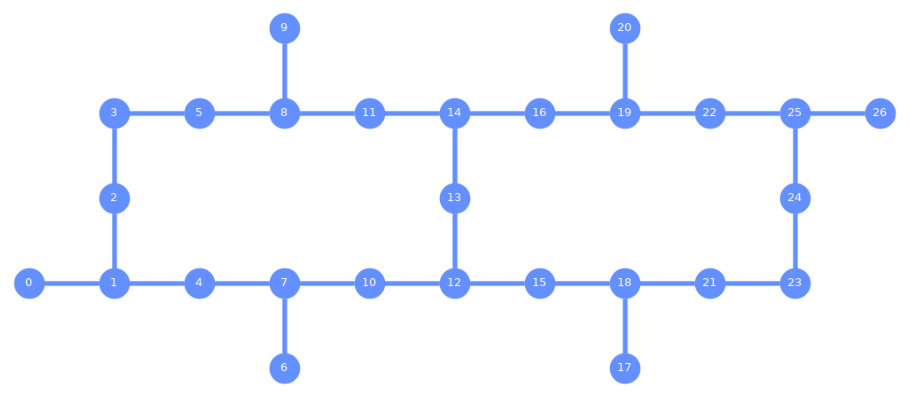

In [28]:
fake_montreal_backend = FakeMontrealV2()

qiskit.visualization.plot_gate_map(fake_montreal_backend)

In [29]:
transpiled_litmus_circuit = transpile(
    litmus_circuit, 
    fake_montreal_backend,
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234
)

transpiled_litmus_circuit.draw(idle_wires=False)

┌───┐                                 
 ancilla_13 -> 5 ───────■────────┤ X ├──■──────────────────────────────
                      ┌─┴─┐      └─┬─┘┌─┴─┐                            
 ancilla_14 -> 8 ─────┤ X ├────────■──┤ X ├────────────────────────────
                 ┌────┴───┴─────┐┌───┐└───┘                       ░    
Litmus_0_1 -> 11 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                 └──────────────┘└─┬─┘                 │          ░    
                 ┌──────────────┐  │  ┌───┐     ┌───┐  │  ┌───┐ Litmus 
Litmus_0_2 -> 13 ┤ Rz(Litmus_2) ├──┼──┤ X ├──■──┤ X ├──┼──┤ X ├───░────
                 ├──────────────┤  │  └─┬─┘┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘   ░    
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■────■──┤ X ├──■──┤ X ├──■─────░────
                 └──────────────┘          └───┘     └───┘        ░

In [30]:
compressed_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=fake_montreal_backend,
    optimization_level=3,
    seed_transpiler=1234,
)

compressed_circuit.draw(idle_wires=False)

┌──────────────┐┌───┐                            ░    
Litmus_0_1 -> 11 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                 └──────────────┘└─┬─┘                 │          ░    
                 ┌──────────────┐  │       ┌───┐       │  ┌───┐ Litmus 
Litmus_0_2 -> 13 ┤ Rz(Litmus_2) ├──┼────■──┤ X ├──■────┼──┤ X ├───░────
                 ├──────────────┤  │  ┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘   ░    
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                 └──────────────┘     └───┘     └───┘└───┘        ░

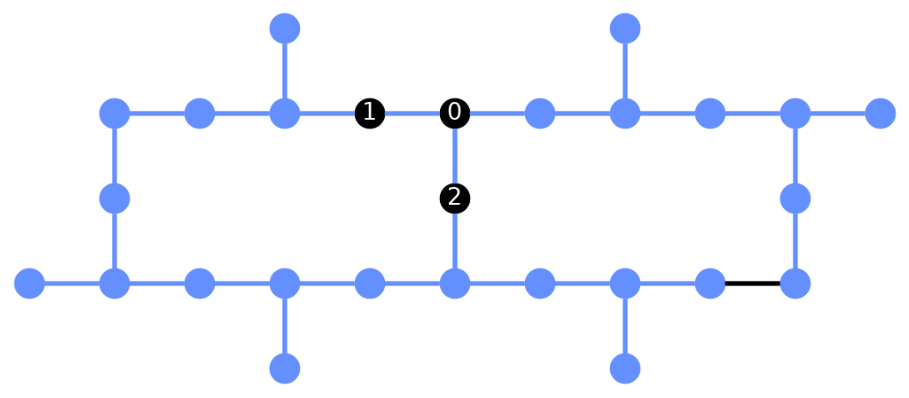

In [31]:
qiskit.visualization.plot_circuit_layout(compressed_circuit, fake_montreal_backend)

`transpile_and_compress` selects topologically most important qubits of a backend
to produce limited coupling map - to decrease transpilation and simulation time:

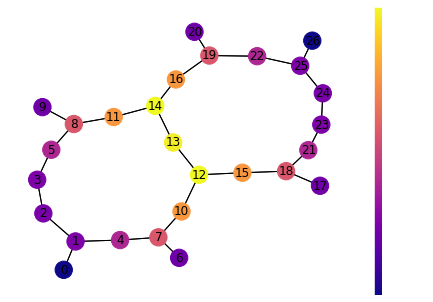

We use flexible measure of a node importance - node “closeness centrality” in the backend topology graph.

Closeness centrality is efficiently calculated using the “rustworkx” graph library function: https://qiskit.org/ecosystem/rustworkx/dev/apiref/rustworkx.closeness_centrality.html

Flexible measure of node importance can be expanded with other metrics. 
For example, neighbors counts or qubit noise levels.

Once importances are calculated - we traverse topology graph using A-star search -
starting from the most important node.

Traversed nodes are added to limited qubit list which forms a connected subgraph.

Discovered subgraph is used to limit the backend topology during transpilation.

### Transpile and Return Metrics

`transpile_and_return_metrics` function transpiles circuit with given parameters and returns transpilation metrics.

In [32]:
transpiled_circuit, metrics = transpile_and_return_metrics(
    litmus_circuit, 
    backend=backend,
    optimization_level=3,
    seed_transpiler=1234
)

In [33]:
transpiled_circuit.draw(fold=-1, idle_wires=False)

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░

In [34]:
metrics[0]

{'pass_index': 0,
 'pass_name': 'ContainsInstruction',
 'pass_type': 'Analysis',
 'time': 1.1682510375976562e-05,
 'depth': 5,
 'width': 3,
 'ibm_cost': 0.9498972910479807,
 'gates_counter': {1: 3, 2: 3}}

### Transpilation Stacks

Four pre-defined transpilation stacks have been added:

- Qiskit transpilation
- Pytket transpilation
- BQSKit QSearch synthesis
- BQSKit QFactor instantiation

#### Synthesis

**Quantum circuit synthesis** is the process of converting a mathematical description of a quantum transformation - often given as a unitary matrix - into a circuit composed of gates from a fixed gate set.

**Search-based** class of synthesis tools is categorized by the discrete search for a desired circuit through a space of circuits. These techniques are usually bottom-up, they start with an empty circuit and grow out as they search through the space.

![image.png](../images/Fig1_circuit_synthesis_schema.jpg)

[1] QFactor: A Domain-Specific Optimizer for Quantum Circuit Instantiation – https://arxiv.org/pdf/2306.08152.pdf

#### QSearch

**QSearch** is a powerful search-based synthesis tool, which phrases the problem of circuit synthesis as a search over circuit structures combined with numerical optimization to instantiate circuit parameters.

1) The algorithm starts by placing single-qubit rotations on all qubits. 

2) The circuit is then instantiated by calling a numerical optimization subroutine to solve for the gate's parameters that minimize the distance between the circuit's unitary and the target unitary. 

3) After this, fixed building blocks composed of two-qubit gates followed by single-qubit rotations are placed on all pairs of qubits. 

This branching pattern forms the circuit tree, where at depth n in the tree, all possible circuit structures with n two-qudit gates exist. 

Each structure is a candidate solution is evaluated using the same numerical optimization process, and the order of evaluations is determined by A* search.

#### Stacks Usage

In [35]:
STACKS = ["qiskit",
          "qiskit_qsearch",
          "qiskit_qfactor_qsearch",
          "qiskit_pytket"]

#### Qiskit

In [36]:
transpiled_circuit = transpile(
    litmus_circuit,
    backend,
    stack="qiskit",
    seed_transpiler=1234)

transpiled_circuit.draw()    

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

#### Pytket

In [37]:
transpiled_circuit = transpile(
    litmus_circuit,
    backend,
    stack="qiskit_pytket",
    seed_transpiler=1234)

transpiled_circuit.draw()    

┌──────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░─
                └──────────────┘└───┘                          ░ 
 ancilla_0 -> 3 ─────────────────────────────────────────────────
                                                                 
 ancilla_1 -> 4 ─────────────────────────────────────────────────

#### QSearch

In [38]:
# Bind Circuit Parameters

bound_litmus_circuit = litmus_circuit.copy()

for index, parameter in enumerate(litmus_circuit.parameters):
    
    bound_litmus_circuit.assign_parameters(
        {parameter: index}, 
        inplace=True)

In [39]:
transpiled_circuit = transpile(
    bound_litmus_circuit,
    backend,
    stack="qiskit_qsearch",
    qsearch_block_size=2,
    seed_transpiler=1234)

transpiled_circuit.draw(fold=-1)    

Frontier emptied.
Returning best known circuit with 0 layers and cost: 2.928933e-01.


global phase: 2.3559
                                                                           ┌────────────┐┌────┐   ┌────────────┐  ┌────┐ ┌───────────┐                                                                   ░ 
      q_0 -> 0 ────────────────────────────────────────────────────────■───┤ Rz(1.5708) ├┤ √X ├───┤ Rz(4.7117) ├──┤ √X ├─┤ Rz(7.854) ├───────────────────────────────────────────────────────────────────░─
               ┌────────────┐┌────┐┌────────────┐┌────┐┌────────────┐┌─┴─┐┌┴────────────┤├────┤┌──┴────────────┴─┐├────┤┌┴───────────┴┐                                                                  ░ 
      q_1 -> 1 ┤ Rz(2.0708) ├┤ √X ├┤ Rz(6.2832) ├┤ √X ├┤ Rz(13.637) ├┤ X ├┤ Rz(-1.5708) ├┤ √X ├┤ Rz(-4.8475e-09) ├┤ √X ├┤ Rz(-1.5708) ├──■───────────────────────────────────────────────────────────────░─
               ├───────────┬┘├────┤└─┬────────┬─┘├────┤├────────────┤└───┘└─────────────┘└────┘└─────────────────┘└────┘└─────────────┘┌─┴─┐┌─────────────┐┌────┐┌─────────────────┐┌────┐┌────────────┐ ░ 
      q_2 -> 2 ┤ Rz(8.854) ├─┤ √X ├──┤ Rz(2π) ├──┤ √X ├┤ Rz(13.137) ├──────────────────────────────────────────────────────────────────┤ X ├┤ Rz(-2.6081) ├┤ √X ├┤ Rz(-0.00024523) ├┤ √X ├┤ Rz(-1.038) ├─░─
               └───────────┘ └────┘  └────────┘  └────┘└────────────┘                                                                  └───┘└─────────────┘└────┘└─────────────────┘└────┘└────────────┘ ░ 
ancilla_0 -> 3 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                           
ancilla_1 -> 4 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

#### QFactor + QSearch

In [40]:
transpiled_circuit = transpile(
    bound_litmus_circuit,
    backend,
    stack="qiskit_qfactor_qsearch",
    qsearch_block_size=2,
    seed_transpiler=1234)

transpiled_circuit.draw(fold=-1)   

Frontier emptied.
Returning best known circuit with 0 layers and cost: 3.507238e-01.


global phase: 3.7614
                                                                                 ┌────┐    ┌───────────┐     ┌────┐    ┌───────────┐              ┌──────────────┐┌────┐┌──────────────┐┌────┐ ┌─────────────┐                                                       
      q_0 -> 0 ───────────────────────────────────────────────────────────■──────┤ √X ├────┤ Rz(-1π/2) ├─────┤ √X ├────┤ Rz(2.299) ├───────────■──┤ Rz(-0.97561) ├┤ √X ├┤ Rz(-0.84364) ├┤ √X ├─┤ Rz(-2.9639) ├───────────────────────────────────────────────────────
               ┌─────────────┐┌────┐ ┌────────────┐┌────┐ ┌───────────┐ ┌─┴─┐┌───┴────┴───┐└───┬────┬──┘┌────┴────┴───┐└───┬────┬──┘┌───────┐┌─┴─┐└──┬───────┬───┘├────┤├─────────────┬┘├────┤┌┴─────────────┴┐                                                      
      q_1 -> 1 ┤ Rz(0.54911) ├┤ √X ├─┤ Rz(6.2832) ├┤ √X ├─┤ Rz(14.33) ├─┤ X ├┤ Rz(3.0964) ├────┤ √X ├───┤ Rz(-1.5708) ├────┤ √X ├───┤ Rz(0) ├┤ X ├───┤ Rz(π) ├────┤ √X ├┤ Rz(-1.5708) ├─┤ √X ├┤ Rz(-0.045233) ├──■───────────────────────────────────────────────────
               └┬────────────┤├────┤┌┴────────────┤├────┤┌┴───────────┴┐└───┘└────────────┘    └────┘   └─────────────┘    └────┘   └───────┘└───┘   └───────┘    └────┘└─────────────┘ └────┘└───────────────┘┌─┴─┐┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐
      q_2 -> 2 ─┤ Rz(-2.984) ├┤ √X ├┤ Rz(-2.8914) ├┤ √X ├┤ Rz(-2.6169) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(-2.442) ├┤ √X ├┤ Rz(5π/2) ├
                └────────────┘└────┘└─────────────┘└────┘└─────────────┘                                                                                                                                       └───┘└─────────┘└────┘└────────────┘└────┘└──────────┘
ancilla_0 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                     
ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Circuit Hash

Function `get_circuit_hash` calculates SHA256 hash for a given quantum circuit.

Hash is based on properties of circuit gates:

- Instruction class (RX, CNOT, CRZ, etc.)
- Parameter values (angles)
- Used qubits
- Used classical bits

Parameter names are ignored - circuits with not-bound RZ("theta_1") and RZ("theta_2") will have equal hashes.

Inspired by Qiskit `soft_compare` gate function:

https://github.com/Qiskit/qiskit/blob/main/qiskit/circuit/instruction.py#L227

In [41]:
get_circuit_hash(litmus_circuit)

100095598721707543281749465799569900477058582496083003953231518177511314776532

In [42]:
get_circuit_hash(transpiled_circuit)

14933620835672132361461908286984305468315039130020404471380212166601340597543

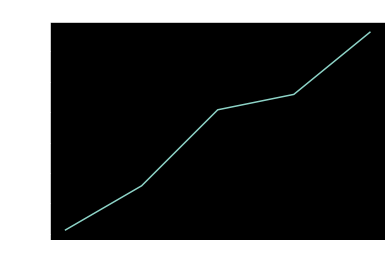

### IBM Cost

IBM Cost is a product of gate fidelities (F) and depth penalization (K):

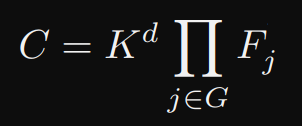

* K - circuit depth penalization factor
* d - circuit depth
* G - gates
* F - fidelities

IBM Cost can be used as circuit quality metric.

[1] “Demonstration of quantum volume 64 on a superconducting quantum computing system” – IBMQ – P. Jurcevic, A. Javadi-Abhari, L. S. Bishop and others – https://arxiv.org/abs/2008.08571

In [43]:
litmus_circuit.draw()

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

In [44]:
get_ibm_cost(litmus_circuit)

0.9498972910479807

In [45]:
transpiled_circuit.draw(fold=-1)

global phase: 3.7614
                                                                                 ┌────┐    ┌───────────┐     ┌────┐    ┌───────────┐              ┌──────────────┐┌────┐┌──────────────┐┌────┐ ┌─────────────┐                                                       
      q_0 -> 0 ───────────────────────────────────────────────────────────■──────┤ √X ├────┤ Rz(-1π/2) ├─────┤ √X ├────┤ Rz(2.299) ├───────────■──┤ Rz(-0.97561) ├┤ √X ├┤ Rz(-0.84364) ├┤ √X ├─┤ Rz(-2.9639) ├───────────────────────────────────────────────────────
               ┌─────────────┐┌────┐ ┌────────────┐┌────┐ ┌───────────┐ ┌─┴─┐┌───┴────┴───┐└───┬────┬──┘┌────┴────┴───┐└───┬────┬──┘┌───────┐┌─┴─┐└──┬───────┬───┘├────┤├─────────────┬┘├────┤┌┴─────────────┴┐                                                      
      q_1 -> 1 ┤ Rz(0.54911) ├┤ √X ├─┤ Rz(6.2832) ├┤ √X ├─┤ Rz(14.33) ├─┤ X ├┤ Rz(3.0964) ├────┤ √X ├───┤ Rz(-1.5708) ├────┤ √X ├───┤ Rz(0) ├┤ X ├───┤ Rz(π) ├────┤ √X ├┤ Rz(-1.5708) ├─┤ √X ├┤ Rz(-0.045233) ├──■───────────────────────────────────────────────────
               └┬────────────┤├────┤┌┴────────────┤├────┤┌┴───────────┴┐└───┘└────────────┘    └────┘   └─────────────┘    └────┘   └───────┘└───┘   └───────┘    └────┘└─────────────┘ └────┘└───────────────┘┌─┴─┐┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐
      q_2 -> 2 ─┤ Rz(-2.984) ├┤ √X ├┤ Rz(-2.8914) ├┤ √X ├┤ Rz(-2.6169) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(-2.442) ├┤ √X ├┤ Rz(5π/2) ├
                └────────────┘└────┘└─────────────┘└────┘└─────────────┘                                                                                                                                       └───┘└─────────┘└────┘└────────────┘└────┘└──────────┘
ancilla_0 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                     
ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [46]:
get_ibm_cost(transpiled_circuit)

0.8529603716177907